# Find words that are similar to other words in the same text

This is an exploration of different ways to compare words in a text to other words in the same text based on their vectors.

Would likely be easier to do this using Gensim, but I am pretty happy with spaCy/numpy approach below.

If semantic similarity would to be developed into a measure of lexical diversity (similar to type-token ratio), I think it should probably be based on a clustering algorithm of some sort.

In [2]:
import spacy
spacy.require_cpu()
nlp = spacy.load('en_core_web_lg')

# doc = nlp('i wrote a letter in a text book document a documents an document an documented written writing.')
doc = nlp('I wrote a long letter to the postman. The missive had many words and the paper it was written on was book quality')

Vectors are calculated on a lexeme basis, so let's first get a list of lexemes in the document, so we don't waste computation comparing different pairs of tokens that have the same underlying lexemes. Importantly, we also make it a set() so that we don't have duplicates.

Lexemes (unlike tokens) do not have a __str__ method, so we have to manually call the .text attribute when we want to print.

## spaCy lexeme approach

In [234]:
lexemes = set([tok.lex for tok in doc])
print([lex.text for lex in lexemes], end = '\n\n')

# get unique pairs of lexemes (order does not matter, lexeme not compared to itself)
from itertools import combinations

sent_combinations = list(combinations(lexemes, 2))
print(str([(lex_1.text, lex_2.text) for lex_1, lex_2 in sent_combinations[:10]])[:-1], '... ]')

['written', 'had', 'to', 'the', '.', 'it', 'paper', 'a', 'long', 'postman', 'words', 'quality', 'on', 'wrote', 'missive', 'I', 'and', 'was', 'book', 'The', 'many', 'letter']

[('written', 'had'), ('written', 'to'), ('written', 'the'), ('written', '.'), ('written', 'it'), ('written', 'paper'), ('written', 'a'), ('written', 'long'), ('written', 'postman'), ('written', 'words') ... ]


In [242]:
'''
{token_a_0: 
        {token_b_0: similarity_to_token_a_0,
         token_b_1: similarity_to_token_a_0}
}
'''
from collections import defaultdict
replacement_dict = defaultdict(dict)
record_of_comparisons = set()

for pair in sent_combinations:
    pair_set = frozenset(pair)
    # if pair_set in record_of_comparisons:
    #     continue # continue to next iteration without completing the rest of the loop
    record_of_comparisons.add(pair_set)
    lex_1, lex_2 = pair
    sim = lex_1.similarity(lex_2)
    # if 0.4 < sim < 1.0:
    #     print(lex_1.text, lex_2.text, sim)
    replacement_dict[lex_1.text][lex_2.text] = sim
    replacement_dict[lex_2.text][lex_1.text] = sim
    
for tok, comparisons in replacement_dict.items():
    neighbor = max(comparisons, key=comparisons.get)
    print(tok, neighbor, round(comparisons[neighbor], 2))

written book 0.57
had was 0.81
to it 0.62
the The 1.0
. it 0.49
it was 0.63
paper book 0.48
a the 0.59
long it 0.6
postman missive 0.33
words written 0.54
quality many 0.42
on the 0.49
wrote written 0.56
missive letter 0.54
I it 0.55
and the 0.56
was had 0.81
book written 0.57
The the 1.0
many it 0.57
letter written 0.56


In [250]:
def replace_alike(orig_sent, replacement_dict, min_sim=.6):
    '''
    orig_sent is a spaCy doc object
    min_sim is a minimum similarity value
    Returns orig_sent as a string with similar words replaced
    '''
    new_sent = ''
    for t in doc:
        comparisons = replacement_dict[t.text]
        nearest = max(comparisons, key=comparisons.get)
        if comparisons[nearest] > min_sim:
            new_sent += nearest + t.whitespace_
        else:
            new_sent += t.text_with_ws
    return new_sent
        
print(replace_alike(doc, replacement_dict, min_sim=0.6))

I wrote a long letter it The postman. the missive was many words and The paper was had written on had book quality


## Scipy cdist approach

In [67]:
import numpy as np

tok_array = np.int64(doc.to_array(['ID'])) # get the ID of each token in the spacy vocabulary and convert to signed int64
print(tok_array.shape)
tok_vecs = np.take(nlp.vocab.vectors.data, tok_array, axis=0) # get the vectors of these items from the spacy vocabulary
print(tok_vecs.shape)

unique_vecs, unique_index, inverse_index, counts = np.unique(tok_vecs, return_index=True, return_inverse=True, return_counts=True, axis=0) # remove duplicates and store indices to reverse operation
print(unique_vecs.shape)
print(np.asarray((unique_index, counts)).T)

assert np.array_equal(tok_vecs, unique_vecs[inverse_index]) # check that we can get back to the redundant array

(24,)
(24, 300)
(21, 300)
[[16  1]
 [23  1]
 [22  1]
 [ 1  1]
 [14  1]
 [19  1]
 [20  1]
 [ 4  1]
 [18  2]
 [17  1]
 [ 8  1]
 [ 2  1]
 [10  1]
 [11  1]
 [12  1]
 [13  1]
 [ 0  1]
 [ 6  3]
 [ 3  1]
 [ 7  1]
 [ 5  1]]


In [80]:
from scipy.spatial.distance import cdist

spacy_similarity_matrix = 1 - cdist(unique_vecs, nlp.vocab.vectors.data, metric='cosine')

In [ ]:
from scipy.spatial.distance import cdist

sims = 1- cdist(unique_vecs, unique_vecs, "cosine")

# assert np.array_equal(cdist(tok_vecs, tok_vecs, "cosine"),
#                       distances[:,inverse_index][inverse_index]) # check that this is equivalent to using the redundant array

sorted_inds = np.argsort(sims, axis=1)[:,-2] # vector is always most similar to itself. we want the second highest similarity.

print('--- insane indexing ---\n')
for tok in doc:
    print(tok.ID)
    i = inverse_index[tok.i]
    print(tok,
          doc[unique_index[sorted_inds[i]]],
          round(distances[i][sorted_inds[i]], 2)
         )    

In [34]:
# display indexes
unique_toks = [doc[i] for i in unique_index]
print(doc)
print(unique_toks)
print(unique_index)
print(inverse_index)
print(sorted_inds)
print(distances[13])


# check that we can get the same results without fancy indexing
print('\n\nMore Sanity checks:\n')
test_distances = distances[:, inverse_index][inverse_index]
# print(np.argsort(test_distances, axis=1))
for i, row in enumerate(test_distances):
    valid_dists = np.where(row > 1e-10)[0]
    most_sim = valid_dists[row[valid_dists].argmin()]
    print(doc[i], doc[most_sim])

i wrote a letter in a text book document a documents an document an documented written writing.
[documented, documents, book, wrote, document, writing, written, letter, an, ., text, a, in, i]
[14 10  7  1  8 16 15  3 11 17  6  2  4  0]
[13  3 11  7 12 11 10  2  4 11  1  8  4  8  0  6  5  9]
[ 1  4  5  6  1  6  5  6 11 13  4  8 11  9]
[0.88494083 0.8844704  0.69453719 0.68763318 0.84045595 0.64664609
 0.74068423 0.74452313 0.76760147 0.62207215 0.73567678 0.69409804
 0.72165744 0.        ]


Sanity check:

i .
wrote written
a an
letter written
in a
a an
text document
book writing
document documents
a an
documents document
an a
document documents
an a
documented documents
written writing
writing written
. i


## Copy spaCy's approach

Modification of the spacy.vectors.most_similar method.

In [153]:
import numpy as np

orth_ids, keys = doc.to_array(['ORTH', 'ID']).T
lex_vecs = nlp.vocab.vectors.get_batch(orth_ids)
print(lex_vecs.shape)

(24, 300)


In [9]:
# import spacy
# nlp = spacy.load('en_core_web_lg')
# doc = nlp('I wrote a long letter to the postman. The missive had many words and the paper it was written on was book quality')

import numpy as np

def most_similar(spacy_doc, batch_size=1024, n=4, sort=True, ignore_identities=True):
    """For each token in the document, find the n most similar tokens
    to it, by cosine.
    Queries are by vector. Results are returned as a `(orth_ids, match_ids,
    scores)` tuple. If the doc is long, the calculations are performed in
    chunks, to avoid consuming too much memory. You can set the `batch_size`
    to control the size/space trade-off during the calculations.
    spacy_doc (spacy.Doc): A spacy Doc with vector tables.
    batch_size (int): The batch size to use.
    n (int): The number of matches to return for each token.
    sort (bool): Whether to sort the n entries returned by score.
    RETURNS (tuple): The most similar entries as a `(orth_ids, match_ids, scores)`
        tuple.
    """
    # Get relevant information about spacy_doc as numpy array
    orth_ids, rows = spacy_doc.to_array(['ORTH', 'ID']).T
    
    # Prepare a dictionary mapping rows to orth_ids
    row2key = {row: key for key, row in zip(orth_ids, rows)}
    
    # Get the vectors from the vector table
    queries = spacy_doc.vocab.vectors.data[rows]
    
    # Deduplicate the queries
    queries, unique, inverse = np.unique(queries, return_index=True, return_inverse=True, axis=0)

    # Normalize the vectors. We care about angle, not magnitude for cosine 'distance'.
    norms = np.linalg.norm(queries, axis=1, keepdims=True)
    norms[norms == 0] = 1
    vectors = queries / norms

    best_rows = np.zeros((queries.shape[0], n), dtype='i')
    scores = np.zeros((queries.shape[0], n), dtype='f')
    
    # Work in batches, to avoid memory problems.
    for i in range(0, queries.shape[0], batch_size):
        batch = queries[i : i+batch_size]
        batch_norms = np.linalg.norm(batch, axis=1, keepdims=True)
        batch_norms[batch_norms == 0] = 1
        batch /= batch_norms
        sims = np.dot(batch, vectors.T) # Cosine 'distance' is pretty simple.
        
        if ignore_identities:
            sims[np.isclose(sims, 1)] = 0
            
        best_rows[i:i+batch_size] = np.argpartition(sims, -n, axis=1)[:,-n:]
        scores[i:i+batch_size] = np.partition(sims, -n, axis=1)[:,-n:]

        if sort and n >= 2:
            sorted_index = np.arange(scores.shape[0])[:,None][i:i+batch_size],np.argsort(scores[i:i+batch_size], axis=1)[:,::-1]
            scores[i:i+batch_size] = scores[sorted_index]
            best_rows[i:i+batch_size] = best_rows[sorted_index]

    for i, j in np.ndindex(best_rows.shape):
        best_rows[i, j] = rows[unique][best_rows[i, j]]
    
    # Round values really close to 1 or -1
    scores = np.around(scores, decimals=4, out=scores)
    # Account for numerical error. We want to return in range -1, 1
    scores = np.clip(scores, a_min=-1, a_max=1, out=scores)
    
    # Align deduplicated results with original queries
    scores = scores[inverse]
    best_rows = best_rows[inverse]
    
    match_ids = np.asarray(
        [[row2key[row] for row in best_rows[i] if row in row2key]
                for i in range(len(vectors)) ], dtype="uint64")
    
    return (orth_ids, match_ids, scores)

test = most_similar(doc)

for tok_id, match_ids, scores in zip(*test):
    print(nlp.vocab.strings[tok_id],
          [(nlp.vocab.strings[match_id], score) for match_id, score in zip(match_ids, scores)])

I [('it', 0.553), ('had', 0.4549), ('was', 0.4447), ('long', 0.4226)]
wrote [('written', 0.5618), ('letter', 0.4247), ('book', 0.4129), ('had', 0.4076)]
a [('the', 0.5926), ('it', 0.5669), ('was', 0.5268), ('to', 0.5059)]
long [('it', 0.5968), ('many', 0.5612), ('had', 0.5052), ('a', 0.4881)]
letter [('written', 0.5598), ('missive', 0.5418), ('words', 0.487), ('paper', 0.4553)]
to [('it', 0.6186), ('the', 0.5877), ('and', 0.5524), ('a', 0.5059)]
the [('it', 0.6153), ('a', 0.5926), ('to', 0.5877), ('and', 0.5625)]
postman [('missive', 0.3305), ('letter', 0.2201), ('I', 0.177), ('wrote', 0.1448)]
. [('it', 0.4871), ('and', 0.4324), ('was', 0.3891), ('long', 0.3811)]
The [('it', 0.6153), ('a', 0.5926), ('to', 0.5877), ('and', 0.5625)]
missive [('letter', 0.5418), ('postman', 0.3305), ('wrote', 0.3258), ('written', 0.3114)]
had [('was', 0.8105), ('it', 0.5681), ('many', 0.5343), ('and', 0.5099)]
many [('it', 0.5702), ('long', 0.5612), ('had', 0.5343), ('and', 0.5133)]
words [('written', 0.

## DBSCAN Approach

In [31]:
import numpy as np

tok_array = np.int64(doc.to_array(['ID'])) # get the ID of each token in the spacy vocabulary and convert to signed int64
# print(tok_array)
tok_vecs = np.take(nlp.vocab.vectors.data, tok_array, axis=0) # get the vectors of these items from the spacy vocabulary
print(tok_vecs.shape)

unique_vecs, unique_index, inverse_index = np.unique(tok_vecs, return_index=True, return_inverse=True, axis=0) # remove duplicates and store indices to reverse operation
print(unique_vecs.shape)
assert np.array_equal(tok_vecs, unique_vecs[inverse_index]) # check that we can get back to the redundant array

(24, 300)
(21, 300)


In [3]:
import numpy as np

from sklearn.cluster import DBSCAN

In [4]:
db = DBSCAN(eps=0.5, metric='cosine', min_samples=1).fit(unique_vecs)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 0


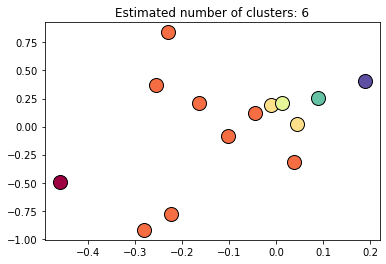

In [6]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = unique_vecs[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = unique_vecs[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

## T-SNE Approach

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


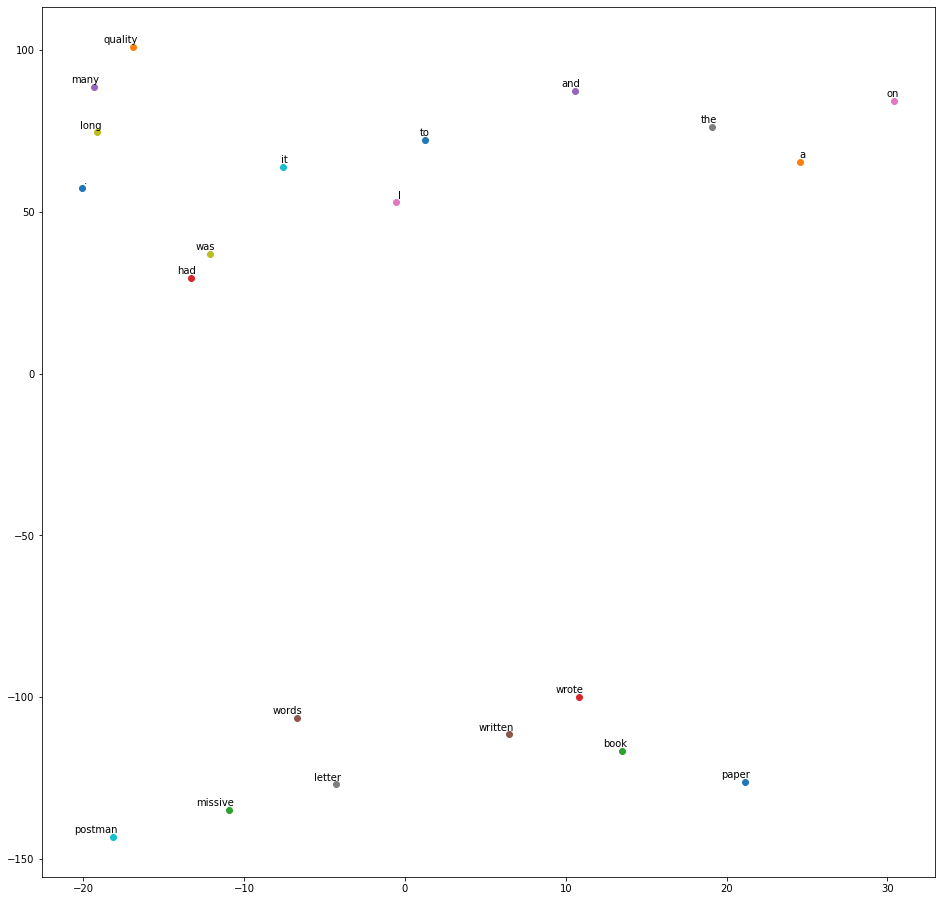

In [48]:
from sklearn.manifold import TSNE
import numpy as np

def tsne_plot(spacy_doc):
    "Creates a TSNE model and plots it."
    
    # get the ID of each token in the spacy vocabulary and convert to signed int64
    tok_array = np.int64(spacy_doc.to_array(['ID']))
    
    # get the vectors of these items from the spacy vocabulary
    tok_vecs = np.take(spacy_doc.vocab.vectors.data, tok_array, axis=0)
    
    # remove duplicates and store indices to reverse operation
    unique_vecs, unique_index = np.unique(tok_vecs,
                                          return_index=True,
                                          axis=0)
    
    labels = [spacy_doc[i].text for i in unique_index]
    
    tsne_model = TSNE(perplexity=2,
                      n_components=2,
                      init='pca',
                      metric='cosine',
                      learning_rate='auto',
                      square_distances=True,
                      n_iter=2500,
                      random_state=42)
    
    coords = tsne_model.fit_transform(unique_vecs)
        
    plt.figure(figsize=(16, 16)) 
    for i, (x, y) in enumerate(coords.tolist()):
        plt.scatter(x, y)
        plt.annotate(labels[i],
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(doc)